<a href="https://colab.research.google.com/github/travislatchman/Neuroimage-Registration-and-Synthesis/blob/main/UNet_Neuro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installations

In [ ]:
!pip install nilearn
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torchviz
!pip install onnx
!pip install torch torchvision
!pip install netron


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=acb9f0edca4df405f1ceb13c9bd5a6c6fc5fa0e9f71f49b0526de5e848e5a919
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 103.0 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr, structural_similarity as ssim
import csv
from torchviz import make_dot
import torch.onnx
import random
import time
import copy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

## MedIA_Project2_registered folder

In [ ]:
class MedIARegisteredDataset(Dataset):
    """
    A class used to represent a Medical Image Analysis (MedIA) Registered Dataset.

    ...

    Attributes
    ----------
    root_dir : str
        The path to the root directory containing the patient folders.
    transform : callable, optional
        An optional transform function to apply to the images.
    patient_ids : list
        A list of patient IDs used to identify the corresponding patient folders.

    Methods
    -------
    __init__(self, root_dir, patient_ids, transform=None):
        Initializes the MedIARegisteredDataset object.
    __len__(self):
        Returns the number of patients in the dataset.
    __getitem__(self, idx):
        Loads and returns a tuple of the input images (T1w and T2w) and target images (FA and ADC) for the patient
        at the given index.
    """

    def __init__(self, root_dir, patient_ids, transform=None):
        """
        Parameters
        ----------
        root_dir : str
            The path to the root directory containing the patient folders.
        patient_ids : list
            A list of patient IDs used to identify the corresponding patient folders.
        transform : callable, optional
            An optional transform function to apply to the images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.patient_ids = patient_ids

    def __len__(self):
        """
        Determines the number of patients in the dataset.

        Returns
        -------
        int
            The number of patients in the dataset.
        """
        return len(self.patient_ids)

    def __getitem__(self, idx):
        """
        Loads and returns a tuple of the input images (T1w and T2w) and target images (FA and ADC) for the patient
        at the given index.

        Parameters
        ----------
        idx : int
            The index of the patient.

        Returns
        -------
        tuple
            A tuple containing two torch.Tensor objects:
            - input_imgs: a torch.Tensor containing the stacked T1w and T2w images.
            - target_imgs: a torch.Tensor containing the stacked FA and ADC images.
        """
        patient_id = self.patient_ids[idx]
        patient_folder = os.path.join(self.root_dir, patient_id)

        # Load the input images (T1w and T2w)
        t1w_path = os.path.join(patient_folder, 'T1w_1mm.nii.gz')
        t2w_path = os.path.join(patient_folder, 'T2w_1mm_noalign.nii.gz')
        t1w_img = nib.load(t1w_path).get_fdata()
        t2w_img = nib.load(t2w_path).get_fdata()

        # Stack the input images along the channel dimension
        input_imgs = np.stack([t1w_img, t2w_img], axis=0)

        # Load the target images (FA and ADC)
        fa_path = os.path.join(patient_folder, 'FA_deformed.nii.gz')
        adc_path = os.path.join(patient_folder, 'ADC_deformed.nii.gz')
        fa_img = nib.load(fa_path).get_fdata()
        adc_img = nib.load(adc_path).get_fdata()

        # Stack the target images along the channel dimension
        target_imgs = np.stack([fa_img, adc_img], axis=0)

        if self.transform:
            input_imgs, target_imgs = self.transform(input_imgs, target_imgs)

        return torch.tensor(input_imgs).float(), torch.tensor(target_imgs).float()

In [ ]:
#root_dir = r"G:\My Drive\Project 2 Neuroimage Synthesis\MedIA_Project2_registered"
root_dir = "/content/drive/My Drive/Project 2 Neuroimage Synthesis/MedIA_Project2_registered"

# Define patient_ids here
patient_ids = [f"{i:03d}" for i in range(1, 201) if i != 163]


## split the patient IDs into training, validation, and testing sets (80/10/10 split)

In [ ]:
# #patient_ids = [str(i).zfill(3) for i in range(1, 201) if i != 163]
rng = np.random.default_rng(seed)
rng.shuffle(patient_ids)

train_size = int(0.8 * len(patient_ids))
val_size = int(0.1 * len(patient_ids))
test_size = len(patient_ids) - train_size - val_size

train_ids = patient_ids[:train_size]
val_ids = patient_ids[train_size:train_size+val_size]
test_ids = patient_ids[train_size+val_size:]

# separate instances of the dataset for each split
train_dataset = MedIARegisteredDataset(root_dir, patient_ids=train_ids)
val_dataset = MedIARegisteredDataset(root_dir, patient_ids=val_ids)
test_dataset = MedIARegisteredDataset(root_dir, patient_ids=test_ids)

# create data loaders for each dataset

batch_size = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


##UNet

In [ ]:
class ConvBlock(nn.Module):
    """
    A class used to represent a convolution block for a 3D U-Net.

    ...

    Attributes
    ----------
    conv : torch.nn.Module
        The convolution layer.
    relu : torch.nn.Module
        The ReLU activation function.

    Methods
    -------
    __init__(self, in_channels, out_channels):
        Initializes the ConvBlock object.
    forward(self, x):
        Performs the forward pass of the convolution block.
    """

    def __init__(self, in_channels, out_channels):
      """
        Parameters
        ----------
        in_channels : int
            The number of input channels.
        out_channels : int
            The number of output channels.
        """
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        """
        Performs the forward pass of the convolution block.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor.

        Returns
        -------
        torch.Tensor
            The output tensor after applying the convolution and the ReLU activation function.
        """
        return self.relu(self.conv(x))


class UNet(nn.Module):
    """
    A class used to represent a 3D U-Net.

    ...

    Attributes
    ----------
    enc1, enc2, enc3, enc4 : ConvBlock
        The encoder blocks.
    pool : torch.nn.Module
        The max pooling layer.
    middle : ConvBlock
        The middle block.
    up4, up3, up2, up1 : torch.nn.Module
        The up-convolution layers.
    dec4, dec3, dec2, dec1 : ConvBlock
        The decoder blocks.
    output : torch.nn.Module
        The output convolution layer.

    Methods
    -------
    __init__(self, in_channels, out_channels):
        Initializes the UNet object.
    forward(self, x):
        Performs the forward pass of the U-Net.
    up_concat(self, up, encode, decode):
        Performs the up-sampling and concatenation operation.
    """
    def __init__(self, in_channels, out_channels):
        """
        Parameters
        ----------
        in_channels : int
            The number of input channels.
        out_channels : int
            The number of output channels.
        """
        super(UNet, self).__init__()

        self.enc1 = ConvBlock(in_channels, 32)
        self.enc2 = ConvBlock(32, 64)
        self.enc3 = ConvBlock(64, 128)
        self.enc4 = ConvBlock(128, 256)

        self.pool = nn.MaxPool3d(2)

        self.middle = ConvBlock(256, 512)

        self.up4 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        self.dec4 = ConvBlock(512, 256)

        self.up3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(256, 128)

        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(128, 64)

        self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(64, 32)

        self.output = nn.Conv3d(32, out_channels, kernel_size=1)

    def forward(self, x):
      """
        Performs the forward pass of the U-Net.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor.

        Returns
        -------
        torch.Tensor
            The output tensor after passing through the U-Net.
        """
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        middle = self.middle(self.pool(enc4))

        up4 = self.up_concat(self.up4, enc4, middle)
        dec4 = self.dec4(up4)

        up3 = self.up_concat(self.up3, enc3, dec4)
        dec3 = self.dec3(up3)

        up2 = self.up_concat(self.up2, enc2, dec3)
        dec2 = self.dec2(up2)

        up1 = self.up_concat(self.up1, enc1, dec2)
        dec1 = self.dec1(up1)

        output = self.output(dec1)

        return output

    def up_concat(self, up, encode, decode):
       """
        Performs the up-sampling and concatenation operation.

        Parameters
        ----------
        up : torch.nn.Module
            The up-convolution layer.
        encode : torch.Tensor
            The output tensor from the corresponding encoder block.
        decode : torch.Tensor
            The output tensor from the previous decoder block.

        Returns
        -------
        torch.Tensor
            The merged tensor after up-sampling and concatenation.
        """
        up = up(decode)
        up = F.interpolate(up, size=encode.size()[2:], mode='trilinear', align_corners=False)
        merge = torch.cat([encode, up], dim=1)
        return merge


In [ ]:
# Create a model instance
model = UNet(in_channels=1, out_channels=2)

# Create a dummy input tensor
x = torch.randn(1, 1, 64, 64, 64)

# Export the model to an ONNX file
torch.onnx.export(model, x, "/content/drive/My Drive/Project 2 Neuroimage Synthesis/Team2/code/Code - Project 2 Data/unet3d.onnx")

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate model
model = UNet(2, 2).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## Train the Model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate model
model = UNet(2, 2).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 100
train_losses = []
val_losses = []
patience = 10
early_stopping_counter = 0
# model_save_path = "model.pt"
# model_save_path = r"G:\My Drive\Project 2 Neuroimage Synthesis\model.pt"
# model_save_path = "/content/drive/My Drive/Project 2 Neuroimage Synthesis/model.pt"
model_save_path = "/content/drive/My Drive/Project 2 Neuroimage Synthesis/Team2/code/Code - Project 2 Data/unet.pt"
best_validation_loss = float('inf')



In [ ]:
train_losses = []
val_losses = []

best_validation_loss = float('inf')
early_stopping_counter = 0
patience = 10

start_time = time.time()

for epoch in range(num_epochs):
    torch.autograd.set_detect_anomaly(True)
    model.train()

    epoch_start_time = time.time()

    train_loss = 0.0
    for i, (input_imgs, target_imgs) in enumerate(train_loader):
        input_imgs = input_imgs.to(device)
        target_imgs = F.interpolate(target_imgs, size=[182, 218, 182], mode='trilinear', align_corners=False)
        #target_imgs = F.interpolate(target_imgs, size=(182, 218, 182), mode='trilinear', align_corners=False)
        target_imgs = target_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(input_imgs)
        loss = criterion(outputs, target_imgs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * input_imgs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = F.interpolate(targets, size=[182, 218, 182], mode='trilinear', align_corners=False)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)


    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    total_training_time = time.time() - start_time

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Epoch Duration: {epoch_duration:.4f} seconds, Total Time: {total_training_time:.4f} seconds')

    if val_loss < best_validation_loss:
        best_validation_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), model_save_path)
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/100, Train Loss: 10.3701, Val Loss: 1.9945, Epoch Duration: 1220.2573 seconds, Total Time: 1220.2578 seconds
Epoch 2/100, Train Loss: 1.3925, Val Loss: 0.9439, Epoch Duration: 129.4910 seconds, Total Time: 1349.8435 seconds
Epoch 3/100, Train Loss: 0.8151, Val Loss: 0.6636, Epoch Duration: 129.4560 seconds, Total Time: 1479.4026 seconds
Epoch 4/100, Train Loss: 0.4843, Val Loss: 0.0232, Epoch Duration: 129.2185 seconds, Total Time: 1608.7228 seconds
Epoch 5/100, Train Loss: 0.0168, Val Loss: 0.0159, Epoch Duration: 130.1015 seconds, Total Time: 1738.9285 seconds
Epoch 6/100, Train Loss: 0.0154, Val Loss: 0.0153, Epoch Duration: 129.4336 seconds, Total Time: 1868.4747 seconds
Epoch 7/100, Train Loss: 0.0149, Val Loss: 0.0149, Epoch Duration: 129.6653 seconds, Total Time: 1998.2429 seconds
Epoch 8/100, Train Loss: 0.0146, Val Loss: 0.0146, Epoch Duration: 129.3313 seconds, Total Time: 2127.6777 seconds
Epoch 9/100, Train Loss: 0.0143, Val Loss: 0.0143, Epoch Duration: 129.9111 se

### save model state

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "unet.pt")


## Train/Val Loss Plot

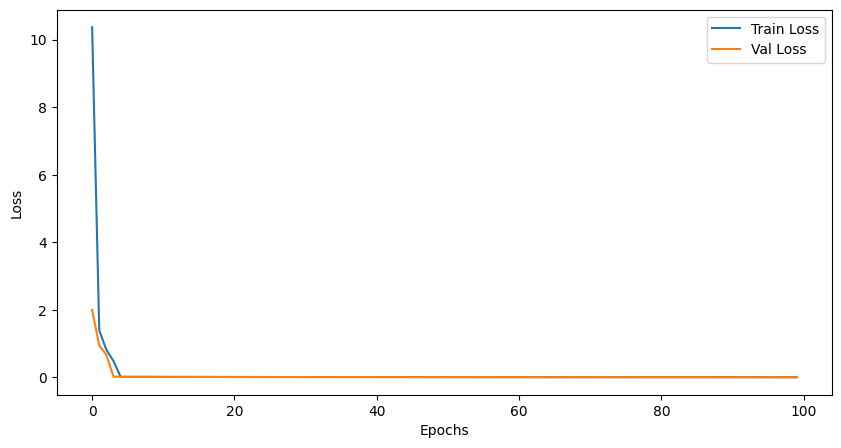

Total training time: 14138.3713 seconds


In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig("/content/drive/My Drive/Project 2 Neuroimage Synthesis/loss_plot.png")
plt.show()

# Total training time
end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.4f} seconds')

##Reload Model

In [ ]:
# Load the model
model_path = "/content/drive/My Drive/Project 2 Neuroimage Synthesis/unet.pt"

# model_path = "/content/drive/My Drive/Project 2 Neuroimage Synthesis/Team2/code/Code - unet.pt"
model.load_state_dict(torch.load(model_path))

# Switch to eval mode
model.eval()


UNet(
  (enc1): ConvBlock(
    (conv): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu): ReLU()
  )
  (enc2): ConvBlock(
    (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu): ReLU()
  )
  (enc3): ConvBlock(
    (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu): ReLU()
  )
  (enc4): ConvBlock(
    (conv): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu): ReLU()
  )
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (middle): ConvBlock(
    (conv): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu): ReLU()
  )
  (up4): ConvTranspose3d(512, 256, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  (dec4): ConvBlock(
    (conv): Conv3d(512, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu): ReLU()
  )
  (up3): ConvTranspose3d(256, 128, kern

## Test - Produce Synthesized Maps of FA and ADC

In [ ]:
import torch
import numpy as np
import os
import nibabel as nib
from nibabel.processing import resample_to_output
import csv
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse

In [ ]:
test_ids

['103',
 '177',
 '140',
 '184',
 '042',
 '111',
 '023',
 '020',
 '165',
 '065',
 '048',
 '114',
 '141',
 '183',
 '015',
 '142',
 '196',
 '037',
 '098',
 '195',
 '137']

In [ ]:
from nilearn.image import resample_img

# Define the new voxel size for resampling
new_voxel_size = (1.25, 1.25, 1.25)

successful_patients = []

with torch.no_grad():
    for i, (input_imgs, target_imgs) in enumerate(test_loader):
        patient_id = test_ids[i]
        print(f"Processing patient {patient_id}")

        # Save the original images for visualization
        original_input_imgs = input_imgs.clone()

        # Move tensors to the device
        input_imgs = input_imgs.to(device)
        target_imgs = target_imgs.to(device)

        # Generate output maps from input images
        outputs = model(input_imgs)

        # Check the number of outputs
        if len(outputs) == 2:
            # Unpack the outputs
            fake_fa, fake_adc = outputs

            # Convert tensors to Nifti images
            fake_fa_nifti = nib.Nifti1Image(fake_fa[0].cpu().numpy(), np.eye(4))
            fake_adc_nifti = nib.Nifti1Image(fake_adc[0].cpu().numpy(), np.eye(4))

            # Resample the images to the new voxel size
            fake_fa_nifti = resample_img(fake_fa_nifti, target_affine=np.diag(new_voxel_size))
            fake_adc_nifti = resample_img(fake_adc_nifti, target_affine=np.diag(new_voxel_size))

            # Save the synthesized FA and ADC maps
            patient_id = test_ids[i]
            patient_folder = os.path.join(root_dir, patient_id)

            fa_syn_path = os.path.join(patient_folder, 'FA_syn.nii.gz')
            adc_syn_path = os.path.join(patient_folder, 'ADC_syn.nii.gz')

            nib.save(fake_fa_nifti, fa_syn_path)
            nib.save(fake_adc_nifti, adc_syn_path)

            # Add the successful patient_id to the list
            successful_patients.append(patient_id)
        elif len(outputs) == 1:
            print(f"Only one output for patient {test_ids[i]}, skipping.")
        else:
            print(f"Unexpected number of outputs for patient {test_ids[i]}, skipping.")

print("Successfully saved patients:", successful_patients)


Processing patient 103
Processing patient 177
Processing patient 140
Processing patient 184
Processing patient 042
Processing patient 111
Processing patient 023
Processing patient 020
Processing patient 165
Processing patient 065
Processing patient 048
Only one output for patient 048, skipping.
Successfully saved patients: ['103', '177', '140', '184', '042', '111', '023', '020', '165', '065']


## Save Metrics (MSE, PSNR, SSIM) to a CSV comparing synthesized FA and ADC maps to original FA and ADC for each patient in test set.

In [ ]:
import csv
import os
import numpy as np
import nibabel as nib
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr, structural_similarity as ssim
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_error

from nilearn.image import resample_to_img


In [ ]:
# Define the headers for the CSV file
headers = ['Patient_ID', 'MSE_FA', 'PSNR_FA', 'SSIM_FA', 'MAE_FA', 'MSE_ADC', 'PSNR_ADC', 'SSIM_ADC', 'MAE_ADC']


# Initialize running sums for calculating the averages
sum_mse_fa, sum_psnr_fa, sum_ssim_fa = 0, 0, 0
sum_mse_adc, sum_psnr_adc, sum_ssim_adc = 0, 0, 0
sum_mae_fa, sum_mae_adc = 0, 0



# Open the CSV file for writing
with open('attention_metrics.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(headers)

    for patient_id in successful_patients:
        patient_folder = os.path.join(root_dir, patient_id)

        fa_syn_path = os.path.join(patient_folder, 'FA_syn.nii.gz')
        adc_syn_path = os.path.join(patient_folder, 'ADC_syn.nii.gz')
        fa_deformed_path = os.path.join(patient_folder, 'FA_deformed.nii.gz')
        adc_deformed_path = os.path.join(patient_folder, 'ADC_deformed.nii.gz')

        fa_syn_nifti = nib.load(fa_syn_path)
        fa_syn = fa_syn_nifti.get_fdata()
        adc_syn_nifti = nib.load(adc_syn_path)
        adc_syn = adc_syn_nifti.get_fdata()

        fa_deformed_nifti = nib.load(fa_deformed_path)
        fa_deformed = fa_deformed_nifti.get_fdata()
        adc_deformed_nifti = nib.load(adc_deformed_path)
        adc_deformed = adc_deformed_nifti.get_fdata()

        # Resample the synthesized FA and ADC images to match the deformed FA and ADC images
        fa_syn_nifti = resample_to_img(fa_syn_nifti, fa_deformed_nifti)
        fa_syn = fa_syn_nifti.get_fdata()
        adc_syn_nifti = resample_to_img(adc_syn_nifti, adc_deformed_nifti)
        adc_syn = adc_syn_nifti.get_fdata()

        mae_fa = mean_absolute_error(fa_syn.flatten(), fa_deformed.flatten())
        mse_fa = mse(fa_syn, fa_deformed)
        psnr_fa = psnr(fa_syn, fa_deformed, data_range=fa_syn.max() - fa_syn.min())
        ssim_fa = ssim(fa_syn, fa_deformed)

        mae_adc = mean_absolute_error(adc_syn.flatten(), adc_deformed.flatten())
        mse_adc = mse(adc_syn, adc_deformed)
        psnr_adc = psnr(adc_syn, adc_deformed, data_range=adc_syn.max() - adc_syn.min())
        ssim_adc = ssim(adc_syn, adc_deformed)

        # Write the metrics to the CSV file
        csv_writer.writerow([patient_id, mse_fa, psnr_fa, ssim_fa, mae_fa, mse_adc, psnr_adc, ssim_adc, mae_adc])

        # Update the running sums
        sum_mse_fa += mse_fa
        sum_psnr_fa += psnr_fa
        sum_ssim_fa += ssim_fa
        sum_mse_adc += mse_adc
        sum_psnr_adc += psnr_adc
        sum_ssim_adc += ssim_adc

        sum_mae_fa += mae_fa
        sum_mae_adc += mae_adc



# Calculate the averages
num_successful_patients = len(successful_patients)
avg_mse_fa = sum_mse_fa / num_successful_patients
avg_psnr_fa = sum_psnr_fa / num_successful_patients
avg_ssim_fa = sum_ssim_fa / num_successful_patients
avg_mse_adc = sum_mse_adc / num_successful_patients
avg_psnr_adc = sum_psnr_adc / num_successful_patients
avg_ssim_adc = sum_ssim_adc / num_successful_patients
avg_mae_fa = sum_mae_fa / num_successful_patients
avg_mae_adc = sum_mae_adc / num_successful_patients


# Output the averages
print("Average MSE FA:", avg_mse_fa)
print("Average PSNR FA:", avg_psnr_fa)
print("Average SSIM FA:", avg_ssim_fa)
print("Average MSE ADC:", avg_mse_adc)
print("Average PSNR ADC:", avg_psnr_adc)
print("Average SSIM ADC:", avg_ssim_adc)
print("Average MAE FA:", avg_mae_fa)
print("Average MAE ADC:", avg_mae_adc)


print("Metrics saved to metrics.csv")

Average MSE FA: 0.032549113481524825
Average PSNR FA: 14.829087339733443
Average SSIM FA: 0.6989486501670562
Average MSE ADC: 0.003323685569761844
Average PSNR ADC: 24.715863547509294
Average SSIM ADC: 0.9539950789508278
Average MAE FA: 0.07557693652318702
Average MAE ADC: 0.011682469192816108
Metrics saved to metrics.csv
